## Análisis de datos - Clase 3

# Taller práctico - análisis de un dataset


En esta clase vamos a analizar en forma completa un dataset con datos de Fórmula 1 de la temporada 2024 (los datos fueron extraídos con la biblioteca Fastf1). El dataset contiene información sobre las carreras, los pilotos, los tiempos y los resultados de cada evento.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
from scipy import stats as st
from scipy.stats import describe

In [3]:
# Dataset de carreras del 2024
raw_GEDEvent = pd.read_csv('../datasets/GEDEvent_v25_1.csv')

/tmp/ipykernel_172533/2568653710.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_GEDEvent = pd.read_csv('../datasets/GEDEvent_v25_1.csv')


---
## EDA (Exploratory Data Analysis)
---

### Columnas y tipos de datos

In [4]:
raw_GEDEvent.columns

Index(['id', 'relid', 'year', 'active_year', 'code_status', 'type_of_violence',
       'conflict_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_dset_id',
       'dyad_new_id', 'dyad_name', 'side_a_dset_id', 'side_a_new_id', 'side_a',
       'side_b_dset_id', 'side_b_new_id', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates',
       'where_description', 'adm_1', 'adm_2', 'latitude', 'longitude',
       'geom_wkt', 'priogrid_gid', 'country', 'country_id', 'region',
       'event_clarity', 'date_prec', 'date_start', 'date_end', 'deaths_a',
       'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best', 'high', 'low',
       'gwnoa', 'gwnob'],
      dtype='object')

In [5]:
# Armamos un nuevo dataset con menos columnas para el análisis
GEDEvent = raw_GEDEvent.drop(columns=['id', 'relid', 'year', 'active_year', 'code_status',
       'conflict_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_dset_id',
       'dyad_new_id', 'dyad_name', 'side_a_dset_id', 'side_a_new_id', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates',
       'where_description', 'adm_2',
       'side_b_dset_id', 'side_b_new_id','geom_wkt', 'priogrid_gid', 'country_id',
       'event_clarity', 'date_prec', 'deaths_a',
       'deaths_b', 'deaths_unknown', 'high', 'low',
       'gwnoa', 'gwnob'], axis=1)

In [6]:
GEDEvent.shape

(385918, 12)

In [7]:
GEDEvent.columns

Index(['type_of_violence', 'side_a', 'side_b', 'adm_1', 'latitude',
       'longitude', 'country', 'region', 'date_start', 'date_end',
       'deaths_civilians', 'best'],
      dtype='object')


### Detalles de las columnas del dataset

### Fecha de inicio y fin
* date_start
* date_end                       

### Coordenadas geográficas    
* latitude
* longitude

### Muertes del evento
* best:                                     La mejor estimación (más probable) del total 
                                            de muertes resultantes de un evento.
* deaths_civilians

### Continente, país y subdivisión     
* region:                                   Africa, Americas, Asia, Europe, Middle East
* country
* adm_1:                                    "Provincia" donde ocurrió el evento

### Tipo de violencia y actores
* type_of_violence:                         1 - conflicto estatal
                                            2 - conflicto no estatal
                                            3 - violencia unilateral
* side_a
* side_b


In [8]:
# Reordeno las columnas para poder identificarlas y analizarlas más cómodamente 
nuevo_orden = ['date_start', 'date_end',                           # Fecha de inicio y fin
               'latitude', 'longitude',                            # Coordenadas geográficas    
               'best', 'deaths_civilians',                         # Muertes del evento
               'region', 'country', 'adm_1',                       # Continente, país y subdivisión
               'type_of_violence', 'side_a', 'side_b',             # Tipo de violencia y actores
]
GEDEvent = GEDEvent[nuevo_orden]

### Vista general del dataset

In [9]:
GEDEvent.head(10)

,date_start,date_end,latitude,longitude,best,deaths_civilians,region,country,adm_1,type_of_violence,side_a,side_b
0,2017-07-31 00:00:00.000,2017-07-31 00:00:00.000,34.531094,69.162796,6,0,Asia,Afghanistan,Kabul province,1,Government of Iraq,IS
1,2021-08-26 00:00:00.000,2021-08-26 00:00:00.000,34.564444,69.217222,183,141,Asia,Afghanistan,Kabul province,1,Government of Iraq,IS
2,2021-08-28 00:00:00.000,2021-08-28 00:00:00.000,34.428844,70.455750,2,0,Asia,Afghanistan,Nangarhar province,1,Government of Iraq,IS
3,2021-08-29 00:00:00.000,2021-08-29 00:00:00.000,34.531094,69.162796,10,10,Asia,Afghanistan,Kabul province,1,Government of Iraq,IS
4,1989-01-07 00:00:00.000,1989-01-13 00:00:00.000,34.333330,70.416670,6,0,Asia,Afghanistan,Nangarhar province,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan
5,1989-01-15 00:00:00.000,1989-01-18 00:00:00.000,36.750000,68.750000,4,0,Asia,Afghanistan,Kunduz province,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan
6,1989-01-23 00:00:00.000,1989-01-24 00:00:00.000,35.315833,69.038889,600,0,Asia,Afghanistan,Baghlan province,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan
7,1989-01-30 00:00:00.000,1989-02-05 00:00:00.000,34.531094,69.162796,2,0,Asia,Afghanistan,Kabul province,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan
8,1989-01-31 00:00:00.000,1989-01-31 00:00:00.000,35.316030,69.038710,70,0,Asia,Afghanistan,Baghlan province,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan
9,1989-02-04 00:00:00.000,1989-02-04 00:00:00.000,34.500000,62.000000,20,0,Asia,Afghanistan,Hirat province,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan


In [10]:
GEDEvent.iloc[0]

date_start          2017-07-31 00:00:00.000
date_end            2017-07-31 00:00:00.000
latitude                          34.531094
longitude                         69.162796
best                                      6
deaths_civilians                          0
region                                 Asia
country                         Afghanistan
adm_1                        Kabul province
type_of_violence                          1
side_a                   Government of Iraq
side_b                                   IS
Name: 0, dtype: object

In [11]:
GEDEvent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385918 entries, 0 to 385917
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date_start        385918 non-null  object 
 1   date_end          385918 non-null  object 
 2   latitude          385918 non-null  float64
 3   longitude         385918 non-null  float64
 4   best              385918 non-null  int64  
 5   deaths_civilians  385918 non-null  int64  
 6   region            385918 non-null  object 
 7   country           385918 non-null  object 
 8   adm_1             366371 non-null  object 
 9   type_of_violence  385918 non-null  int64  
 10  side_a            385918 non-null  object 
 11  side_b            385918 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 35.3+ MB


In [12]:
# Me fijo si hay algún valor raro en posición
GEDEvent[(GEDEvent['latitude'] < -90) | (GEDEvent['latitude'] > 90)]

,date_start,date_end,latitude,longitude,best,deaths_civilians,region,country,adm_1,type_of_violence,side_a,side_b


### Ajustamos los tipos de datos

In [13]:

         
# Numéricas temporales         
GEDEvent['date_start'] = pd.to_datetime(GEDEvent['date_start'])
GEDEvent['date_end'] = pd.to_datetime(GEDEvent['date_end'])

# Categóricas
GEDEvent['region'] = GEDEvent['region'].astype('category')
GEDEvent['country'] = GEDEvent['country'].astype('category')
GEDEvent['adm_1'] = GEDEvent['adm_1'].astype('category')
GEDEvent['type_of_violence'] = GEDEvent['type_of_violence'].astype('category')
GEDEvent['side_a'] = GEDEvent['side_a'].astype('category')
GEDEvent['side_b'] = GEDEvent['side_b'].astype('category')




In [14]:
GEDEvent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385918 entries, 0 to 385917
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date_start        385918 non-null  datetime64[ns]
 1   date_end          385918 non-null  datetime64[ns]
 2   latitude          385918 non-null  float64       
 3   longitude         385918 non-null  float64       
 4   best              385918 non-null  int64         
 5   deaths_civilians  385918 non-null  int64         
 6   region            385918 non-null  category      
 7   country           385918 non-null  category      
 8   adm_1             366371 non-null  category      
 9   type_of_violence  385918 non-null  category      
 10  side_a            385918 non-null  category      
 11  side_b            385918 non-null  category      
dtypes: category(6), datetime64[ns](2), float64(2), int64(2)
memory usage: 21.1 MB


---

---
### Variables categóricas: exploración
---

In [15]:
GEDEvent[GEDEvent['best'] == '0']

,date_start,date_end,latitude,longitude,best,deaths_civilians,region,country,adm_1,type_of_violence,side_a,side_b


In [16]:
GEDEvent.describe(include='category')

,region,country,adm_1,type_of_violence,side_a,side_b
count,385918,385918,366371,385918,385918,385918
unique,5,124,1682,3,966,959
top,Middle East,Syria,Rif Dimashq governorate,1,Government of Syria,Syrian insurgents
freq,122215,87861,17487,271331,75181,66186


#### Corredor y equipo

In [28]:
# Top 10 Actor A
GEDEvent['side_a'].unique()

['Government of Iraq', 'Government of Afghanistan', 'Government of India', 'Government of Tajikistan', 'Government of Pakistan', ..., 'Al-Maraziq', 'Forces of the Presidential Leadership Council', 'Abu al-Abbas Brigades', 'Giants Brigade, STC', 'Government of United Kingdom, Government of U...]
Length: 966
Categories (966, object): ['16th Division, Islamic Front, Jabhat Fateh al..., '1920 Revolution Brigades', '23rd Division, Ahrar al-Sham, Jaysh al Nasr, ..., '23rd Division, Jaysh al Nasr, Jaysh al-Nukhba..., ..., 'al-Qaida', 'al-Tawhid Brigade', 'anti-Balaka', 'anti-Balaka, FPRC-AK']

In [31]:
print(GEDEvent['side_a'].value_counts().head(10))

print(GEDEvent['side_b'].value_counts().head(10))

side_a
Government of Syria                    75181
Government of Afghanistan              40223
Government of Russia (Soviet Union)    32460
Government of India                    13011
IS                                     12257
Government of Israel                    9524
Jalisco Cartel New Generation           9146
Government of Myanmar (Burma)           8220
Government of Turkey                    8014
Government of Bosnia-Herzegovina        7908
Name: count, dtype: int64
side_b
Syrian insurgents                         66186
Civilians                                 59605
Taleban                                   35935
Government of Ukraine                     28499
IS                                        21871
Sinaloa Cartel                             9816
PKK                                        7656
Kashmir insurgents                         7237
Hamas                                      5863
Serbian Republic of Bosnia-Herzegovina     5702
Name: count, dtype: int64


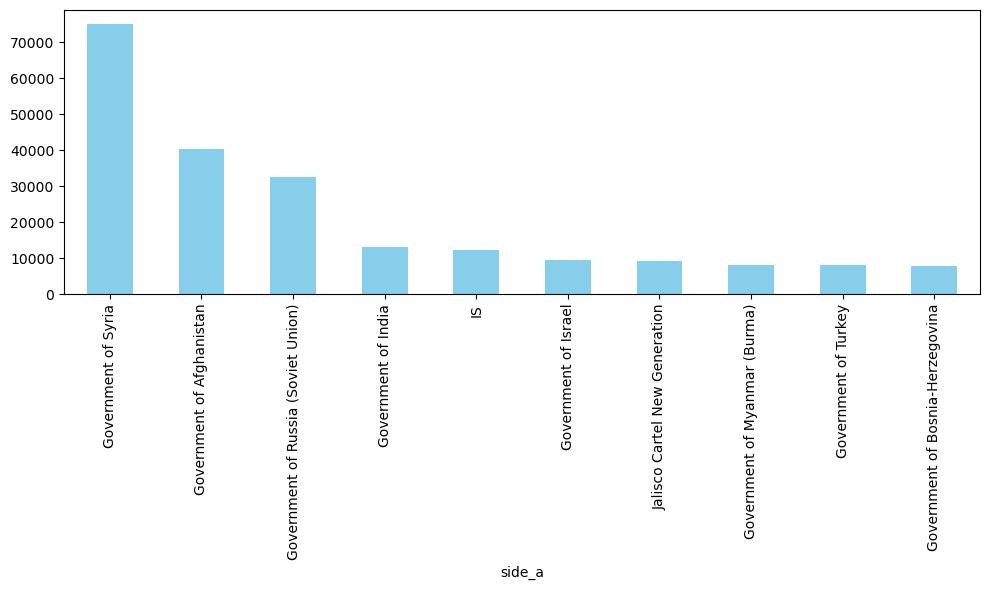

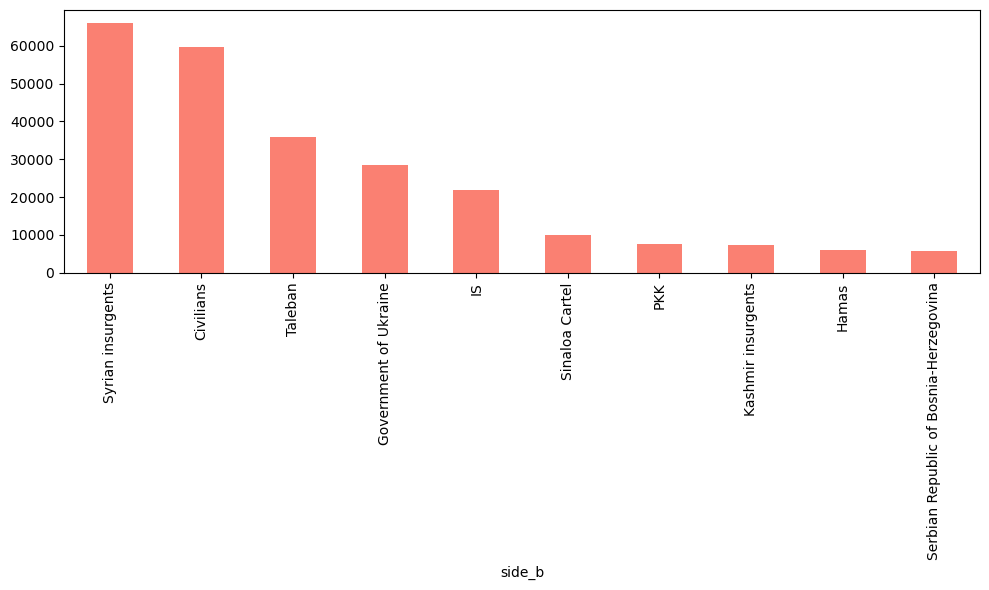

In [25]:
top_10a = GEDEvent['side_a'].value_counts().head(10)
top_10a.plot(kind='bar', figsize=(10, 6), color='skyblue')

plt.tight_layout()
plt.show()

top_10b = GEDEvent['side_b'].value_counts().head(10)
top_10b.plot(kind='bar', figsize=(10, 6), color='salmon')

plt.tight_layout()
plt.show()
